# 1D Fast Accurate Fourier Transform
## Complex to Complex

In [45]:
import numpy as np
import ctypes
from ctypes import *

import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math


In [46]:
%matplotlib inline    


## Loading FFT routines

In [47]:
gridDIM = 64

size = gridDIM

segment = 0

normFactor = 0.0


DIR_BASE = "/home/robert/Documents/new1/FFT/code/FAFT-7/FAFT/FAFT128_C2C-master/"

# FAFT 
_faft128_1D = ctypes.cdll.LoadLibrary( DIR_BASE+'FAFT128_1D_C2C.so' )
_faft128_1D.FAFT128_1D_C2C.restype = int
_faft128_1D.FAFT128_1D_C2C.argtypes = [ctypes.c_void_p, ctypes.c_float, ctypes.c_float, ctypes.c_int, ctypes.c_float]

cuda_faft = _faft128_1D.FAFT128_1D_C2C


In [48]:
def Gaussian(x,mu,sigma):
    return np.exp( - (x-mu)**2/sigma**2/2. , dtype=np.float32 )/(sigma*np.sqrt( 2*np.pi  ))

def fftGaussian(p,mu,sigma):
    return np.exp(-1j*mu*p , dtype=np.float32 )*np.exp( - p**2*sigma**2/2. , dtype=np.float32 )

## Initializing a Gaussian

 Amplitude x =  7.0
 Amplitude p =  5.0
        
sigma =  1.0
n     =  64
dx    =  0.21875
dp    =  0.15625
           standard fft dp =  0.448798950513      
    
delta =  0.00543986621896
    
The Gaussian extends to the numerical error in single precision:
  extremes  (8.16624e-17+0j)  ,  (3.50208e-07+0j)


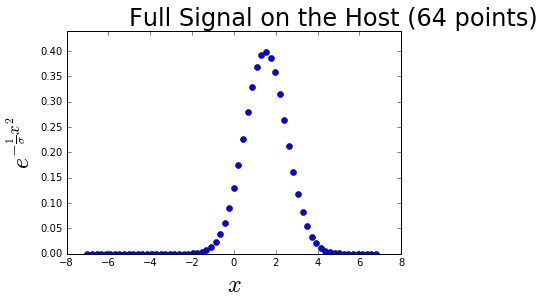

In [49]:
# Gaussian parameters
mu = 1.5
sigma = 1.

# Grid parameters
x_amplitude = 7.
p_amplitude = 5.                # With the traditional method p amplitude is fixed to: 2 * np.pi /( 2*x_amplitude ) 

dx = 2*x_amplitude/float(size)  # This is beta in Bailey's paper
dp = 2*p_amplitude/float(size)  # This is gamma in Bailey's paper

delta = dx*dp/(2*np.pi)

x = np.linspace( -x_amplitude, x_amplitude-dx, size)  
p = np.linspace( -p_amplitude, p_amplitude-dx, size) 

f = Gaussian( x, mu, sigma )

f = f + 1j*np.zeros_like(f)

plt.plot( x, f.real,'o' )

axis_font = {'size':'24'}
plt.text( -5, .45, 'Full Signal on the Host (64 points)' , **axis_font)
plt.ylabel('$e^{-\\frac{1}{\\sigma }x^2}$',**axis_font)
plt.xlabel('$x$',**axis_font)

plt.ylim(0,0.44)

print ' Amplitude x = ',x_amplitude
print ' Amplitude p = ',p_amplitude
print '        '

print 'sigma = ', sigma
print 'n     = ', x.size
print 'dx    = ', dx
print 'dp    = ', dp
print '           standard fft dp = ',2 * np.pi /( 2*x_amplitude ) , '     '
print '    '
print 'delta = ', delta


print '    '

print 'The Gaussian extends to the numerical error in single precision:'  
print '  extremes ', f[0], ' , ', f[-1]


In [50]:
F_gpu = gpuarray.zeros( ( 1, gridDIM ), dtype=np.complex64 )

F_gpu[:] = f[np.newaxis, :]

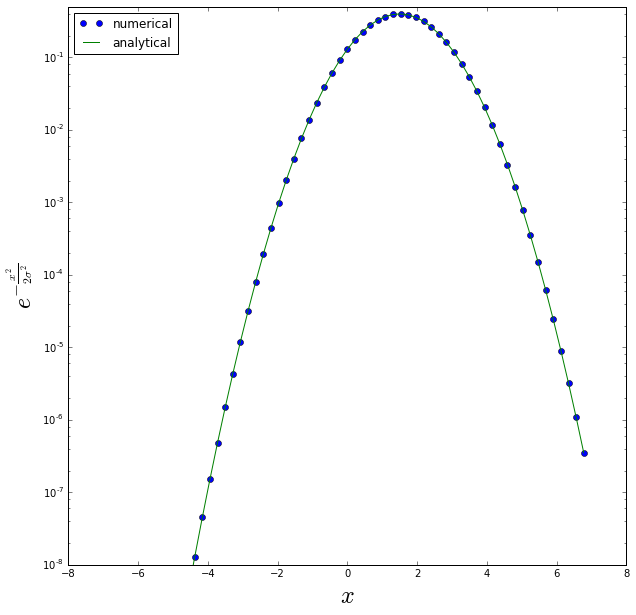

In [51]:
# LOG PLOT 

plt.figure(figsize=(10,10))

plt.semilogy( x, F_gpu.get().real.reshape(64)  , 'o', label='numerical')

plt.semilogy( x, mlab.normpdf(x, mu, sigma) , label = 'analytical')

plt.legend(loc='upper left')

plt.ylim(1e-8,0.5)

plt.ylabel('$e^{- \\frac{x^2}{2 \\sigma^2 } }$',**axis_font)
plt.xlabel('$x$',**axis_font)

### Forward Transform

In [52]:
# Executing FFT

cuda_faft( int(F_gpu.gpudata), dx, delta, segment, normFactor )

1

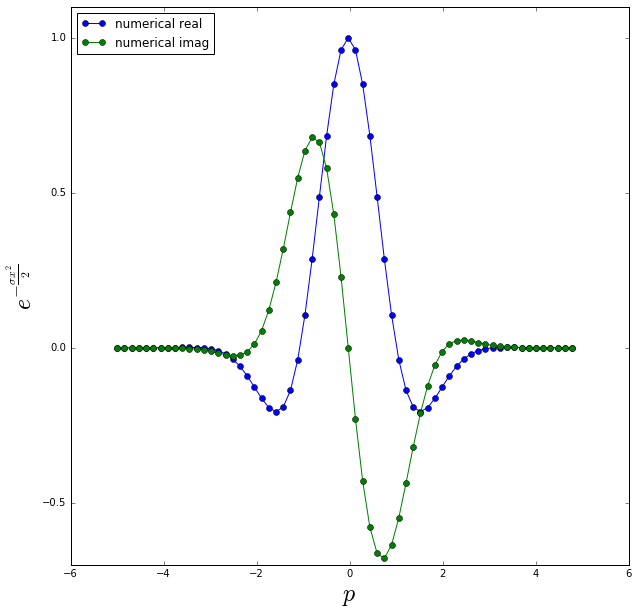

In [53]:
plt.figure(figsize=(10,10))

plt.plot( p, F_gpu.get().real.reshape(64)/(2*F_gpu.get().size) , 'o-', label='numerical real')
plt.plot( p, F_gpu.get().imag.reshape(64)/(2*F_gpu.get().size) , 'o-', label='numerical imag')

plt.legend(loc='upper left')

plt.ylim(-0.7,1.1)

plt.ylabel('$e^{- \\frac{\\sigma x^2}{2} }$',**axis_font)
plt.xlabel('$p$',**axis_font)

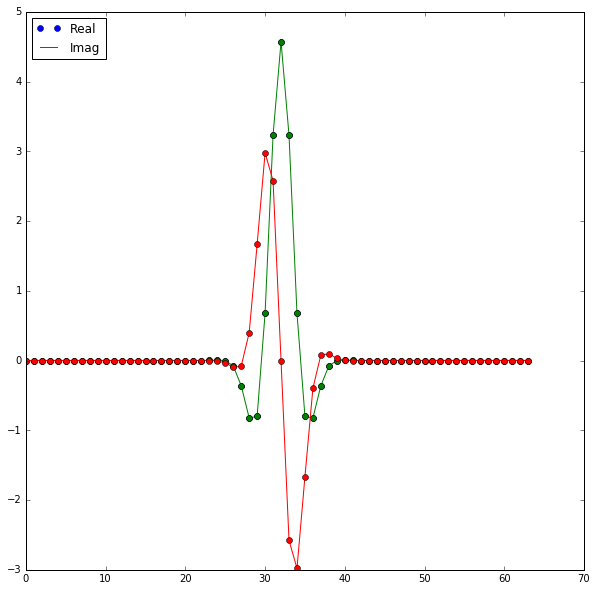

In [54]:
# Standard fft :
# Observe how much memory is lost in zeros 

plt.figure(figsize=(10,10))
plt.plot( np.fft.fftshift( np.fft.fft( np.fft.fftshift(f)  ) ).real  ,'o',  label='Real')
plt.plot( np.fft.fftshift( np.fft.fft( np.fft.fftshift(f)  ) ).real  ,'o-'  )
plt.plot( np.fft.fftshift( np.fft.fft( np.fft.fftshift(f)  ) ).imag  ,'r-', label='Imag')
plt.plot( np.fft.fftshift( np.fft.fft( np.fft.fftshift(f)  ) ).imag  ,'ro')

plt.legend(loc='upper left')


### Inverse

In [55]:
# For Inverse Transform, enter "-delta"

cuda_faft( int(F_gpu.gpudata), dx, -delta, segment, normFactor )

1

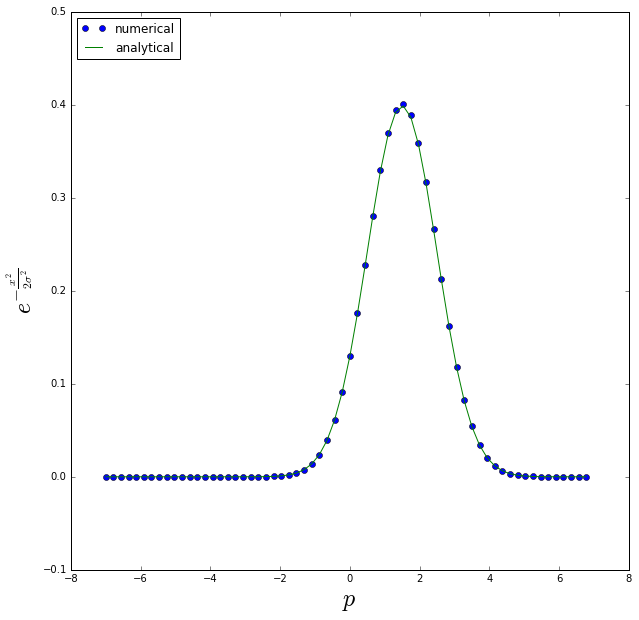

In [56]:
plt.figure(figsize=(10,10))

plt.plot( x, F_gpu.get().real.reshape(64)/ (2*F_gpu.get().size)/(17.5*F_gpu.get().size), 'o', label='numerical')

plt.plot( x, mlab.normpdf(x, mu, sigma) , label = 'analytical')

plt.legend(loc='upper left')

#plt.ylim(0,0.5)

plt.ylabel('$e^{- \\frac{x^2}{2 \\sigma^2 } }$',**axis_font)
plt.xlabel('$p$',**axis_font)

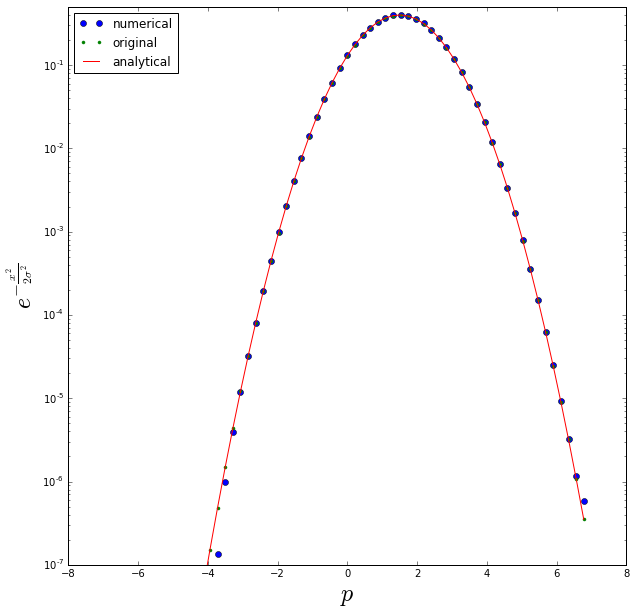

In [57]:
# LOG PLOT 

plt.figure(figsize=(10,10))

plt.semilogy( x, F_gpu.get().real.reshape(64)/ (2*F_gpu.get().size)/(17.5*F_gpu.get().size)  , 'o', label='numerical')

plt.semilogy( x, f  , '.', label='original')

plt.semilogy( x, mlab.normpdf(x, mu, sigma) , label = 'analytical')

plt.legend(loc='upper left')

plt.ylim(1e-7,0.5)

plt.ylabel('$e^{- \\frac{x^2}{2 \\sigma^2 } }$',**axis_font)
plt.xlabel('$p$',**axis_font)